In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [258]:
def sanity_check(matrix):
    if not np.allclose(np.linalg.norm(matrix,axis=1),1):
        raise ValueError("At least one non unit vector")
    return True

def project_and_calc_dist(X,Y,theta,p):
    
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    #N,d = X.shape
    qs = np.linspace(0,1,50)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")

    
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p

    #mu = np.mean(dist_p)
    #var  =np.var(dist_p)

    #print(mu*mu/var)
    #print(mu/var)
    return dist_p


def activation(vector):
    return np.exp(vector)/np.exp(vector).sum()


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed


In [330]:
mx = np.array([1,1,3,0,0])
Var_X = np.diag([1,2,3,4,5])
my = np.array([0,0,1,2,3])
#my=mx
Var_Y = np.eye(5)
N= 10000
X_N = np.random.multivariate_normal(mx,Var_X,size=N)
Y_N = np.random.multivariate_normal(my,Var_Y,size=N)
THETA = sample_theta(X_N,num_smaples=1000)
x_proj = np.dot(X_N,THETA.T)
y_proj = np.dot(Y_N,THETA.T)

In [331]:
Var_X_est = pd.DataFrame(X_N).cov().values
mx_est = np.mean(X_N,axis=0)
projected_var_x = (np.linalg.norm(mx_est,axis=0)**2/5 + np.trace(Var_X_est)/5)
true_projected_varx = (np.linalg.norm(mx,axis=0)**2/5 + np.trace(Var_X)/5)
print("True Var after Projection: \n {:.4f}".format(true_projected_varx))
print("Estimated based on X: \n {:.6f}".format(projected_var_x))
Var_X_after_proj = np.var(x_proj,axis=1).mean()
print("Estimated Var after Projection: \n {:.6f}".format(Var_X_after_proj))

True Var after Projection: 
 5.2000
Estimated based on X: 
 5.241693
Estimated Var after Projection: 
 5.177964


In [332]:
Var_Y_est = pd.DataFrame(Y_N).cov().values
my_est = np.mean(Y_N,axis=0)
projected_var_y = (np.linalg.norm(my_est,axis=0)**2/5 + np.trace(Var_Y_est)/5)
true_projected_vary = (np.linalg.norm(my,axis=0)**2/5 + np.trace(Var_Y)/5)
print("True Var after Projection: \n {:.4f}".format(true_projected_vary))
print("Estimated based on X: \n {:.6f}".format(projected_var_y))
Var_Y_after_proj = np.var(y_proj,axis=1).mean()
print("Estimated Var after Projection: \n {:.6f}".format(Var_Y_after_proj))

True Var after Projection: 
 3.8000
Estimated based on X: 
 3.798238
Estimated Var after Projection: 
 3.861187


##### Idea

get a distribution for each quantile to then build the difffernce for each distribution 

Example: 

$q_X \sim MVN(\mu_{qx},\Sigma_{qx})$
$q_Y \sim MVN(\mu_{qy},\Sigma_{qy})$


$\sum_{i=0}^{qs}|q_X[i]-q_Y[i]|^{2}$ should be RV with Gamma Distribution.

Since $Z_i = q_X[i]-q_Y[i] \sim \mathcal{N}$  and $|\tilde{Z}_{i}| = |Z_{i}-\mathbb{E}[Z_{i}]| \sim HN(\sigma^{2}) $

and $|\tilde{Z}_{i}|^{2} \sim \Gamma(0.5,\beta_{i})$

Problem will be $\beta$ 

In [395]:
#### Compute quantiles of Projections for each column 

qs = np.linspace(0,1,100)

x_proj_q = np.quantile(x_proj,qs,axis=0)
y_proj_q = np.quantile(y_proj,qs,axis=0)

TRACE_X_est = np.trace(Var_X_est)/5
TRACE_Y_est = np.trace(Var_Y_est)/5

print('Comparison to var of projection')
print(np.var(x_proj_q,axis=1).mean()+TRACE_X_est)
print(np.var(y_proj_q,axis=1).mean()+TRACE_Y_est)


print('Actual sample Variance')
print(np.var(x_proj_q,axis=1).mean())
print(np.var(y_proj_q,axis=1).mean())


Comparison to var of projection
5.214598742673248
3.8660620413276297
Actual sample Variance
2.1744139191618834
2.864608441446651


In [396]:
Q_mean = np.mean(x_proj_q,axis=1)-np.mean(y_proj_q,axis=1)
Q_var = np.var(x_proj_q,axis=1)+np.var(y_proj_q,axis=1)


diff_quantiles = x_proj_q - y_proj_q


diff_quantiles_normalised = np.zeros((len(qs),1000))
for t in range(len(qs)):
    diff_quantiles_normalised[t,:] = diff_quantiles[t,:] - Q_mean[t]

print(diff_quantiles.shape)
##### Verteilung pro q 

Diff_2  = pd.DataFrame(np.abs(diff_quantiles)**2)


for t in range(len(qs)):
    m = Diff_2.iloc[t,:].mean()
    v = Diff_2.iloc[t,:].var()
    print(t)
    print("###########")
    print("a", m**2/v)
    print('b', v/m)

### mean is actually near a*b of fitted Gamma to output
Diff_2.mean(axis=1)


(100, 1000)
0
###########
a 0.7141196019245422
b 18.545087388492277
1
###########
a 0.5668711336265755
b 11.881174017499582
2
###########
a 0.553720075680346
b 10.95420337719299
3
###########
a 0.5526066877860668
b 10.265405613919864
4
###########
a 0.553813570556835
b 9.749524159857884
5
###########
a 0.5564055156293521
b 9.335981785560861
6
###########
a 0.5600052892602919
b 8.97338397380975
7
###########
a 0.5644089423152603
b 8.65577648222474
8
###########
a 0.5696405222868883
b 8.36344288469373
9
###########
a 0.5758779646444955
b 8.085847930789125
10
###########
a 0.5818759131143697
b 7.8383100535240375
11
###########
a 0.5876014522550247
b 7.620610778776182
12
###########
a 0.5943023177386764
b 7.410126294031724
13
###########
a 0.6008197781148299
b 7.21856458913456
14
###########
a 0.6074942876747517
b 7.035110977722228
15
###########
a 0.6144155376100864
b 6.862253025760765
16
###########
a 0.6211424301230927
b 6.701801193506798
17
###########
a 0.6282575854926981
b 6.54954932

0     13.243410
1      6.735095
2      6.065562
3      5.672732
4      5.399419
        ...    
95     5.322155
96     5.583577
97     5.973678
98     6.626988
99    13.342830
Length: 100, dtype: float64

In [419]:
Diff_2.var(axis=1)

0     245.600204
1      80.020831
2      66.443403
3      58.232893
4      52.641764
         ...    
95     47.781758
96     52.913642
97     60.446157
98     73.246041
99    246.301168
Length: 100, dtype: float64

In [416]:
np.abs(Q_mean)**2+2*np.abs(Q_mean)


array([14.6416506 ,  6.37452985,  5.35689933,  4.74143043,  4.29684266,
        3.95421391,  3.66524131,  3.4234234 ,  3.20948913,  3.01955705,
        2.84502473,  2.68557915,  2.54238613,  2.40810106,  2.28478619,
        2.16851216,  2.05949054,  1.95673091,  1.85825806,  1.76535708,
        1.67596773,  1.59062751,  1.51015939,  1.4317014 ,  1.35640561,
        1.28349432,  1.21362794,  1.14719963,  1.0824768 ,  1.02006971,
        0.95852958,  0.89948826,  0.84249064,  0.78688715,  0.73278796,
        0.68106641,  0.62964206,  0.57951443,  0.53073732,  0.48329279,
        0.4358076 ,  0.39023017,  0.34568391,  0.30209923,  0.25873358,
        0.21713696,  0.17597449,  0.13550352,  0.09633587,  0.0577147 ,
        0.01968664,  0.01774477,  0.05593084,  0.09478696,  0.13460621,
        0.17536128,  0.21625654,  0.25849979,  0.30144949,  0.34550267,
        0.39038974,  0.43583827,  0.483206  ,  0.53139765,  0.58095536,
        0.63160534,  0.68400826,  0.7379603 ,  0.79319926,  0.85

In [389]:
((Diff_2.var(axis=1))/100)

0      2.456002
1      1.291553
2      1.146780
3      1.054032
4      0.995062
         ...   
995    0.921226
996    0.985594
997    1.071738
998    1.233270
999    2.463012
Length: 1000, dtype: float64

<Axes: ylabel='Density'>

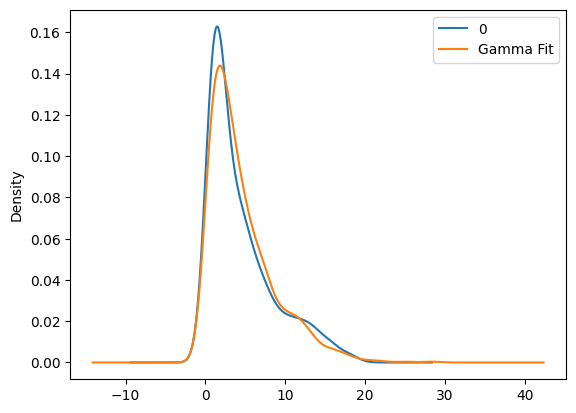

In [369]:
fig2,ax2  = plt.subplots()

W2 = pd.DataFrame(project_and_calc_dist(X_N,Y_N,THETA,p=2).mean(axis=0))
W2.plot.kde(ax=ax2)

b= W2.var()/W2.mean()
a = W2.mean()**2/W2.var()


#pd.DataFrame(np.random.noncentral_chisquare(2,1,1000),columns=['Non central chi squared']).plot.kde(ax=ax2)


pd.DataFrame(np.random.gamma(a,b,1000),columns=['Gamma Fit']).plot.kde(ax=ax2)


In [370]:
print(a,b)

0    1.148441
dtype: float64 0    3.864646
dtype: float64


In [376]:
a*b
(a*b**2)**0.5

0    4.141562
dtype: float64

In [280]:
(1/2/(1/diff_quantiles_normalised.var(axis=1))).sum()

np.float64(140.35069556136264)

In [193]:
#### ql times L matrix
diff_quantiles = x_proj_q - y_proj_q

(np.var(x_proj_q,axis=1)+np.var(y_proj_q,axis=1)).mean()

diff_quantiles.var(axis=1)

array([3.95005431, 2.93186878, 2.88045703, 2.88111364, 2.87952402,
       2.87241521, 2.87040395, 2.87157463, 2.86478876, 2.85025021,
       2.84545007, 2.84207816, 2.83245767, 2.83016088, 2.82586935,
       2.82421098, 2.82142926, 2.81568365, 2.81632208, 2.80992566,
       2.8007102 , 2.79261665, 2.79192516, 2.79456058, 2.79067915,
       2.7868046 , 2.78370254, 2.77825569, 2.7712362 , 2.77098077,
       2.77023468, 2.76718232, 2.7654975 , 2.75883996, 2.75595509,
       2.75327431, 2.75540853, 2.75186241, 2.75118933, 2.75102743,
       2.75266897, 2.75153251, 2.74916328, 2.7480474 , 2.74970595,
       2.75066587, 2.7508124 , 2.74883728, 2.74894791, 2.7468881 ,
       2.74462822, 2.74843268, 2.74364515, 2.74650424, 2.74508627,
       2.74369939, 2.7390572 , 2.73721715, 2.73572513, 2.73640798,
       2.73966866, 2.74052842, 2.73582344, 2.73919158, 2.73864255,
       2.74013341, 2.74064078, 2.743398  , 2.74663901, 2.74998923,
       2.75244106, 2.76041585, 2.76009258, 2.76501139, 2.76430

### $\Gamma$-Process

$X_{t}=X_{t-1} + \epsilon_{t}$ with $\epsilon_{t} \sim \Gamma(\alpha,\beta)$

with random changes Gamma distribution at $t=100,200$

array([<Axes: title={'center': 'Hist of Process'}>], dtype=object)

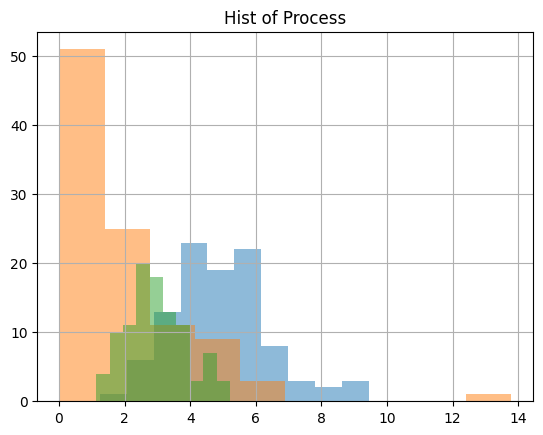

In [147]:
Gamma1 =np.random.gamma(10,0.5,100)
Gamma2 = np.random.gamma(1,2,100)
Gamma3 = np.random.gamma(10,0.3,100)

Process = pd.DataFrame(np.hstack((Gamma1,Gamma2,Gamma3)),columns=['Hist of Process'])

fig, ax = plt.subplots()
Process[:100].hist(ax=ax,alpha=0.5)
Process[100:200].hist(ax=ax,alpha=0.5)
Process[200:].hist(ax=ax,alpha=0.5)


<Axes: >

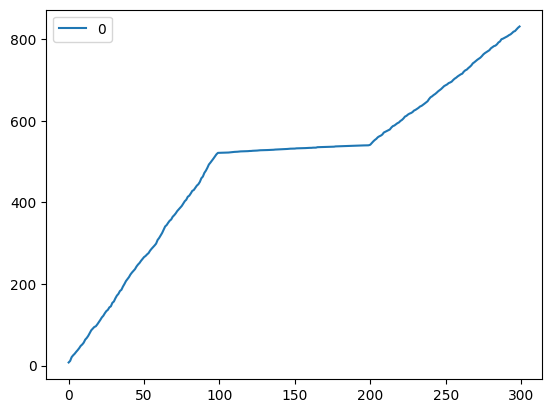

In [138]:
pd.DataFrame(np.hstack((Gamma1,Gamma2,Gamma3))).cumsum().plot()